# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

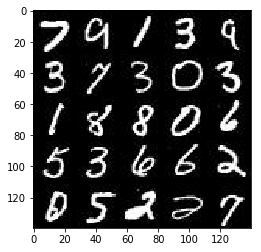

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

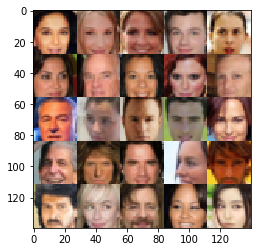

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_images')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        d1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * d1, d1)
        
        d2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(d2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        
        d3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(d3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 2*2*512)
        g1 = tf.reshape(g1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(0.2 * bn1, bn1)
         
        g2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        
        g3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(g3, training=is_train)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    iterations = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                iterations += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if iterations % 100 == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                if iterations % 10 == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

          
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1550... Generator Loss: 5.0949
Epoch 1/2... Discriminator Loss: 0.1455... Generator Loss: 7.1992
Epoch 1/2... Discriminator Loss: 0.0171... Generator Loss: 5.5437
Epoch 1/2... Discriminator Loss: 3.0923... Generator Loss: 17.3198
Epoch 1/2... Discriminator Loss: 0.6522... Generator Loss: 13.9570
Epoch 1/2... Discriminator Loss: 0.5467... Generator Loss: 13.5025
Epoch 1/2... Discriminator Loss: 0.0967... Generator Loss: 8.4226
Epoch 1/2... Discriminator Loss: 2.1609... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 0.3220... Generator Loss: 3.4993


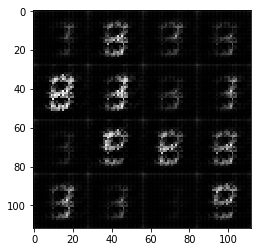

Epoch 1/2... Discriminator Loss: 0.3220... Generator Loss: 3.1689
Epoch 1/2... Discriminator Loss: 0.6312... Generator Loss: 1.1314
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.6884
Epoch 1/2... Discriminator Loss: 0.1045... Generator Loss: 3.3321
Epoch 1/2... Discriminator Loss: 0.5233... Generator Loss: 7.2863
Epoch 1/2... Discriminator Loss: 0.3584... Generator Loss: 4.4053
Epoch 1/2... Discriminator Loss: 0.3424... Generator Loss: 2.0848
Epoch 1/2... Discriminator Loss: 2.4457... Generator Loss: 0.1438
Epoch 1/2... Discriminator Loss: 0.6269... Generator Loss: 1.5745
Epoch 1/2... Discriminator Loss: 0.2246... Generator Loss: 2.9699


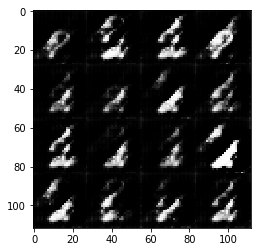

Epoch 1/2... Discriminator Loss: 0.3133... Generator Loss: 1.8756
Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 1.8133
Epoch 1/2... Discriminator Loss: 0.4617... Generator Loss: 1.9139
Epoch 1/2... Discriminator Loss: 0.3455... Generator Loss: 2.5987
Epoch 1/2... Discriminator Loss: 0.4743... Generator Loss: 1.8749
Epoch 1/2... Discriminator Loss: 0.2682... Generator Loss: 2.3936
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 5.0102
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 1.9583
Epoch 1/2... Discriminator Loss: 0.6051... Generator Loss: 1.5312
Epoch 1/2... Discriminator Loss: 0.2728... Generator Loss: 2.3170


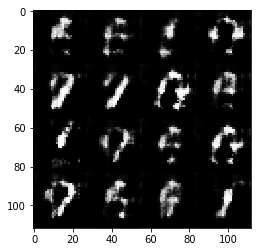

Epoch 1/2... Discriminator Loss: 0.3885... Generator Loss: 4.6480
Epoch 1/2... Discriminator Loss: 0.2586... Generator Loss: 2.5841
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 1.6861
Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 3.4624
Epoch 1/2... Discriminator Loss: 0.5695... Generator Loss: 1.6395
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 0.3771... Generator Loss: 3.3188
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 0.3491... Generator Loss: 2.6587
Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 1.1805


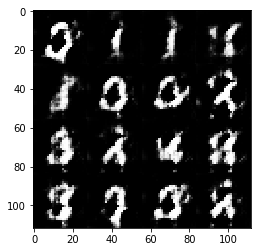

Epoch 1/2... Discriminator Loss: 0.3224... Generator Loss: 1.8783
Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 1.5318
Epoch 1/2... Discriminator Loss: 0.2671... Generator Loss: 3.0937
Epoch 1/2... Discriminator Loss: 0.4968... Generator Loss: 2.4594
Epoch 1/2... Discriminator Loss: 0.6958... Generator Loss: 4.6330
Epoch 1/2... Discriminator Loss: 0.3996... Generator Loss: 2.1221
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 3.7517
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 1.6190


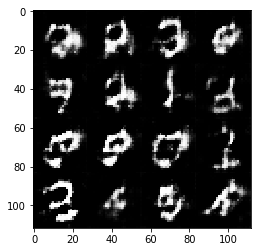

Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 2.0249
Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 2.4784
Epoch 1/2... Discriminator Loss: 0.6419... Generator Loss: 1.6982
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 2.0252
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 1.8992
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.6290
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 1.8299
Epoch 1/2... Discriminator Loss: 0.5052... Generator Loss: 2.1450
Epoch 1/2... Discriminator Loss: 0.5592... Generator Loss: 1.6693
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 0.9100


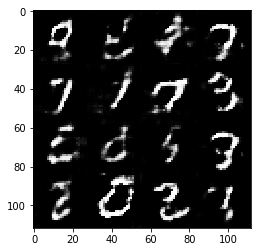

Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 1.3794
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 0.6342... Generator Loss: 1.3860
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 1.9289
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 3.2378
Epoch 1/2... Discriminator Loss: 0.7042... Generator Loss: 1.2825
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 1.3820
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.4020


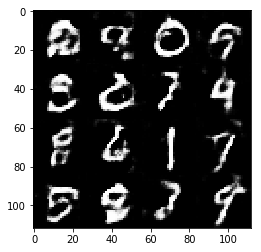

Epoch 1/2... Discriminator Loss: 0.7405... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.6119
Epoch 1/2... Discriminator Loss: 0.7034... Generator Loss: 1.7913
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 1.8603
Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 1.9136
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 2.6175
Epoch 1/2... Discriminator Loss: 0.7729... Generator Loss: 1.9146
Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 1.4204
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 2.3255
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 0.9351


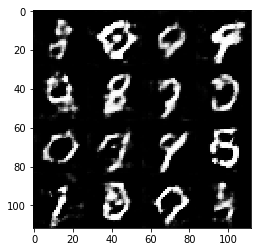

Epoch 1/2... Discriminator Loss: 0.7294... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 3.0793
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 1.4528
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.1991
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 1.9858
Epoch 1/2... Discriminator Loss: 0.7005... Generator Loss: 1.4959
Epoch 1/2... Discriminator Loss: 0.8664... Generator Loss: 2.4375
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 1.2539


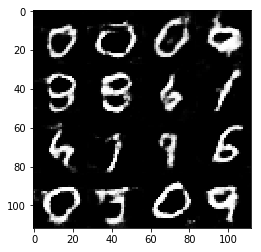

Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.4233
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 1.7839
Epoch 1/2... Discriminator Loss: 0.5378... Generator Loss: 1.6148
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.1806
Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 2.6357
Epoch 2/2... Discriminator Loss: 0.5933... Generator Loss: 2.1196
Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.3579


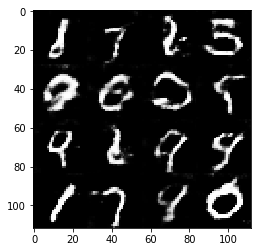

Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.4944
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 1.1359
Epoch 2/2... Discriminator Loss: 0.7186... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.1502
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 1.9223
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 1.0799
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 2.5468
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.5901
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.1150


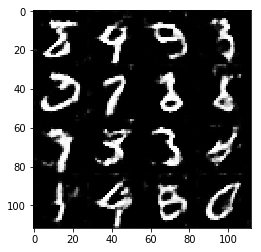

Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.5313
Epoch 2/2... Discriminator Loss: 0.6617... Generator Loss: 1.3850
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.0189
Epoch 2/2... Discriminator Loss: 0.6094... Generator Loss: 1.5442
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 2.3951... Generator Loss: 0.1919
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 2.8588


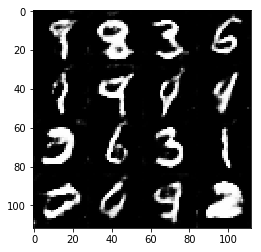

Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 0.9458
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.3389
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.8960
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 0.6305... Generator Loss: 1.2285
Epoch 2/2... Discriminator Loss: 0.6512... Generator Loss: 2.0548
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.0802
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.5476


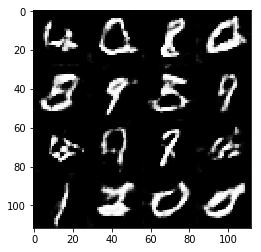

Epoch 2/2... Discriminator Loss: 0.7418... Generator Loss: 1.2713
Epoch 2/2... Discriminator Loss: 1.9572... Generator Loss: 0.2278
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.2049
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 1.0191
Epoch 2/2... Discriminator Loss: 1.8358... Generator Loss: 3.7708
Epoch 2/2... Discriminator Loss: 0.7857... Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 1.4294
Epoch 2/2... Discriminator Loss: 1.1572... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 0.5699


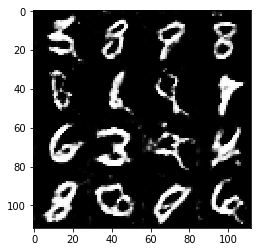

Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.7293
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 2.2030... Generator Loss: 0.2556
Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.2094
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.8703
Epoch 2/2... Discriminator Loss: 0.5411... Generator Loss: 1.3888
Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 1.0144
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 0.8424... Generator Loss: 1.4842


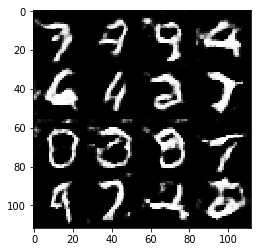

Epoch 2/2... Discriminator Loss: 0.7148... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.5192
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.2109
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.5034
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 2.2871
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.4519
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.0403
Epoch 2/2... Discriminator Loss: 0.6643... Generator Loss: 2.0660


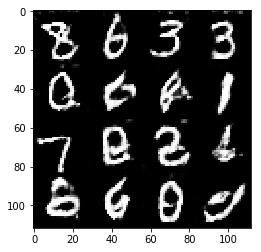

Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 1.8214
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 1.5051
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.4886
Epoch 2/2... Discriminator Loss: 0.6941... Generator Loss: 0.9407
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 1.7055
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 2.5938
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 0.5637... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.6186


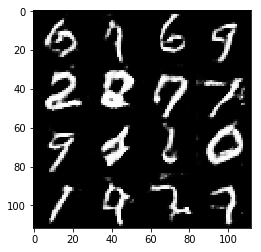

Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 2.5198
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.8141
Epoch 2/2... Discriminator Loss: 0.7956... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 2.3037
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.0350


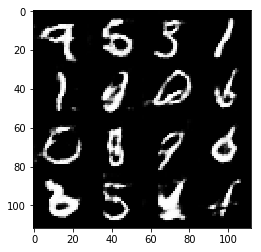

Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 2.0496
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 0.5994
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 0.9477
Epoch 2/2... Discriminator Loss: 0.5465... Generator Loss: 1.2988
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.8271
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.2453


In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1504... Generator Loss: 0.0513
Epoch 1/1... Discriminator Loss: 0.2259... Generator Loss: 12.2120
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 19.3312
Epoch 1/1... Discriminator Loss: 3.8209... Generator Loss: 0.0228
Epoch 1/1... Discriminator Loss: 0.0877... Generator Loss: 7.8281
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 1.4678
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 1.8598
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 5.1464


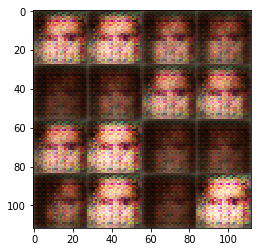

Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 3.7925
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.4210
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 7.2782
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 2.8768
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 0.8687


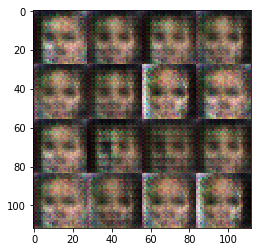

Epoch 1/1... Discriminator Loss: 2.5452... Generator Loss: 0.1394
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 3.8385
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 1.5053
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 0.9151


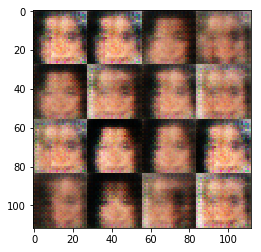

Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 2.4165
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 2.8407
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 2.0579
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 2.4888
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 2.4913
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.8521


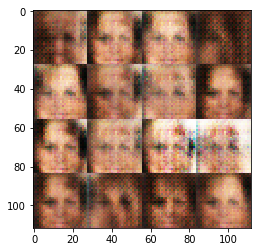

Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 2.3000
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.8231


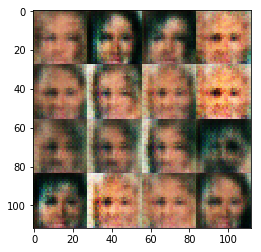

Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.7675
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 2.1203
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 3.7587
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.5249
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.8019


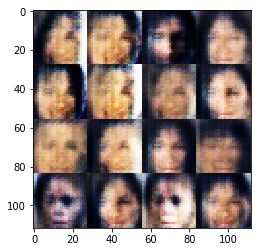

Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.7291
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.9258
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.3034


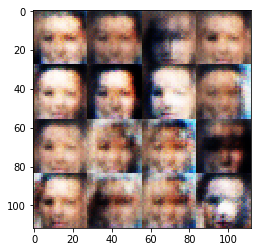

Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.5921
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.7571
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.7937


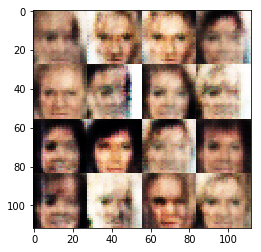

Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 2.2352
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.9546
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 1.4770


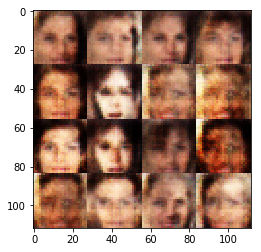

Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 3.3373
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 0.6151... Generator Loss: 1.4656
Epoch 1/1... Discriminator Loss: 1.9821... Generator Loss: 0.2531
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.3788


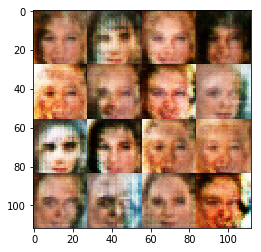

Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 2.3857
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.6956
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.4884


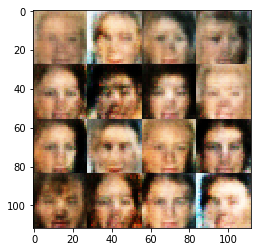

Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 2.4437
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 2.1521
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.4724


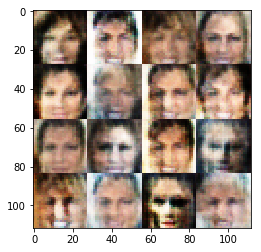

Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.7365
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 0.9561


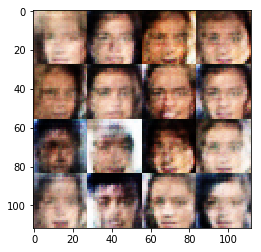

Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.6435
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.6498
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.8638
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.9474


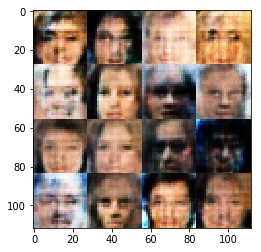

Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.4397
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 2.0209
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 2.3004


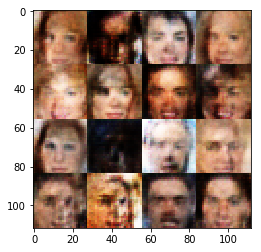

Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.4943
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.4850
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.2987


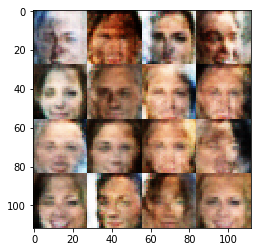

Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 0.2870
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.8898
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 2.2940
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.4375


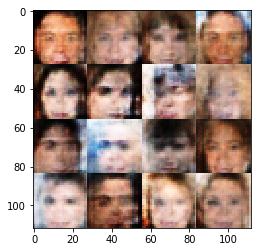

Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 2.6339
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.8609
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.9886
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.4523


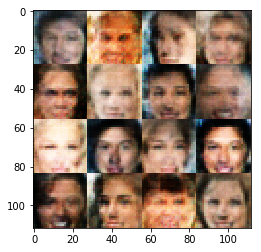

Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.4913
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.6353


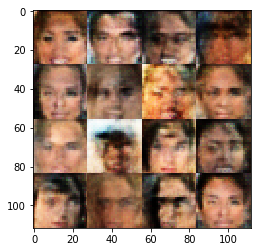

Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.4334
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.2302


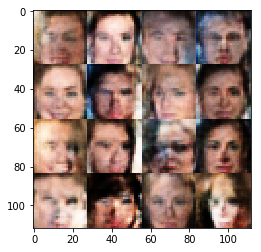

Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.9554
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.6250
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.8143
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.0846


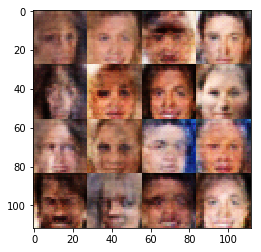

Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.4351
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.7405
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.6882


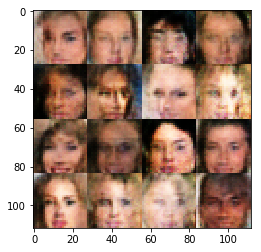

Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 2.0112
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.7153
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 2.1100
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.7540
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.8407


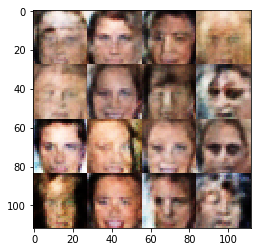

Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.3676
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 2.6871
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.3662
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.1485


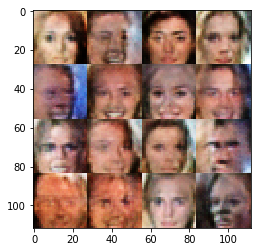

Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.7331
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 0.7269... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1083


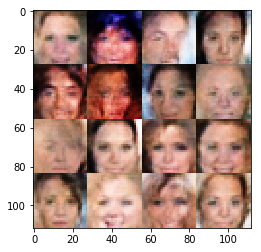

Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.8337
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.6141
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 2.0073
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.2078


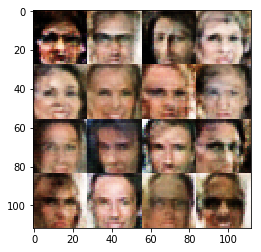

Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.9271
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.6814
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.8282


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.